In [16]:
# Import necessary libraries
import pandas as pd

# Load the expression data and metadata
expression_path = 'ERP009868.tsv'
expression_data = pd.read_csv(expression_path, sep='\t', index_col=0)

metadata_path = 'updated_metadata_ERP009868.tsv'
metadata = pd.read_csv(metadata_path, sep='\t', index_col=0)

# Transpose the expression data to have samples as rows and genes as columns
expression_data = expression_data.T

# Calculate variances for each gene and select the top 5,000 most variable genes
variances = expression_data.var(axis=0)
top_genes = variances.nlargest(5000).index
expression_data_subset = expression_data[top_genes]

# Prepare metadata to merge with expression data
expression_data_subset.index.name = 'SampleID'
metadata_reset = metadata.reset_index().rename(columns={'refinebio_accession_code': 'SampleID'})

# Merge expression data with metadata on 'SampleID'
data = expression_data_subset.merge(metadata_reset, on='SampleID')

# Create 'mutation_status' based on 'refinebio_title'
data['mutation_status'] = data['refinebio_title'].apply(
    lambda x: 'reference' if x == 'Danio rerio' else 'mutant'
)


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target variable
X = data[top_genes]  # Keep only gene expression columns
y = data['mutation_status']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Print shapes of training and testing sets to confirm setup
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Training set target distribution:\n", y_train.value_counts())
print("Testing set target distribution:\n", y_test.value_counts())


Training set shape: (1320, 5000)
Testing set shape: (566, 5000)
Training set target distribution:
 mutation_status
reference    1236
mutant         84
Name: count, dtype: int64
Testing set target distribution:
 mutation_status
reference    530
mutant        36
Name: count, dtype: int64


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Initialize and train the Logistic Regression model
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)
print("Logistic Regression model trained for predicting two groups.")

# Make predictions and evaluate the model
y_pred = logistic_model.predict(X_test)
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]

# Calculate the AUC for ROC
auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC Score for group prediction:", auc_score)

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


Logistic Regression model trained for predicting two groups.
AUC Score for group prediction: 1.0
Classification Report:
               precision    recall  f1-score   support

      mutant       1.00      1.00      1.00        36
   reference       1.00      1.00      1.00       530

    accuracy                           1.00       566
   macro avg       1.00      1.00      1.00       566
weighted avg       1.00      1.00      1.00       566



In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split

# Step 2e: Predicting Clusters with Logistic Regression
# Load cluster labels
y_clusters = metadata['clusters']

# Count samples in each cluster to check distribution
cluster_counts = y_clusters.value_counts()
print("Cluster counts:\n", cluster_counts)

# Filter out clusters with fewer than two samples
valid_clusters = cluster_counts[cluster_counts >= 2].index
X_filtered = X[y_clusters.isin(valid_clusters)]
y_clusters_filtered = y_clusters[y_clusters.isin(valid_clusters)]

# Confirm the shapes after filtering
print("Filtered X shape:", X_filtered.shape)
print("Filtered y_clusters shape:", y_clusters_filtered.shape)

# Split data for cluster prediction with stratification
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(
    X_filtered, y_clusters_filtered, test_size=0.3, random_state=42, stratify=y_clusters_filtered
)

# Initialize and train the Logistic Regression model for multi-class prediction
logistic_model_clusters = LogisticRegression(random_state=42, multi_class='ovr')
logistic_model_clusters.fit(X_train_cl, y_train_cl)
print("Logistic Regression model trained for cluster prediction.")

# Make predictions and evaluate the model
y_pred_clusters = logistic_model_clusters.predict(X_test_cl)
y_pred_proba_clusters = logistic_model_clusters.predict_proba(X_test_cl)

# Calculate sample-specific AUC scores for each cluster class (one-vs-rest for multi-class)
auc_scores_clusters = []
for i in range(y_pred_proba_clusters.shape[1]):
    # Check if the current class exists in y_test_cl
    if (y_test_cl == i).sum() > 0 and (y_test_cl != i).sum() > 0:
        auc = roc_auc_score((y_test_cl == i).astype(int), y_pred_proba_clusters[:, i])
        auc_scores_clusters.append((i, auc))
    else:
        auc_scores_clusters.append((i, "AUC not defined for single-class"))

# Display AUC scores and classification report
print("Sample-specific AUC Scores for cluster prediction:", auc_scores_clusters)
print("Classification Report for Cluster Prediction:\n", classification_report(y_test_cl, y_pred_clusters))


Cluster counts:
 clusters
106    141
110    130
104     96
101     82
96      79
      ... 
1        1
24       1
25       1
26       1
0        1
Name: count, Length: 112, dtype: int64
Filtered X shape: (1859, 5000)
Filtered y_clusters shape: (1859,)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression model trained for cluster prediction.
Sample-specific AUC Scores for cluster prediction: [(0, 'AUC not defined for single-class'), (1, 'AUC not defined for single-class'), (2, 'AUC not defined for single-class'), (3, 'AUC not defined for single-class'), (4, 'AUC not defined for single-class'), (5, 'AUC not defined for single-class'), (6, 'AUC not defined for single-class'), (7, 'AUC not defined for single-class'), (8, 0.1732495511669659), (9, 'AUC not defined for single-class'), (10, 'AUC not defined for single-class'), (11, 'AUC not defined for single-class'), (12, 'AUC not defined for single-class'), (13, 'AUC not defined for single-class'), (14, 'AUC not defined for single-class'), (15, 'AUC not defined for single-class'), (16, 'AUC not defined for single-class'), (17, 'AUC not defined for single-class'), (18, 0.6609712230215827), (19, 'AUC not defined for single-class'), (20, 'AUC not defined for single-class'), (21, 'AUC not defined for single-class'), (22, 'AU

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [47]:
import pandas as pd

# Load each prediction file with its specific column name
def load_prediction(file_path, pred_col):
    df = pd.read_csv(file_path)
    if pred_col in df.columns:
        return df[pred_col]
    else:
        print(f"Warning: Column '{pred_col}' not found in {file_path}.")
        return None

# Group prediction columns based on actual column names
group_predictions = {
    "Naive Bayes (Group)": load_prediction("naive_bayes_predictions.csv", "Predicted"),
    "KNN (Group)": load_prediction("knn_predictions.csv", "predicted"),
    "Logistic Regression (Group)": load_prediction("LR_group_predictions.csv", "Predicted_Label")
}

# Cluster prediction columns based on actual column names
cluster_predictions = {
    "Naive Bayes (Cluster)": load_prediction("naive_bayes_cluster_predictions.csv", "Predicted_Cluster"),
    "KNN (Cluster)": load_prediction("knn_cluster_predictions.csv", "predicted_cluster"),
    "Logistic Regression (Cluster)": load_prediction("LR_cluster_predictions.csv", "Predicted_Label")
}

# Filter out any None values (i.e., files without the specified column)
group_predictions = {k: v for k, v in group_predictions.items() if v is not None}
cluster_predictions = {k: v for k, v in cluster_predictions.items() if v is not None}

# Combine group predictions into a DataFrame and calculate class counts
if group_predictions:
    group_matrix = pd.DataFrame(group_predictions)
    group_matrix.index.name = 'SampleID'
    group_class_counts = group_matrix.apply(pd.Series.value_counts, axis=1).fillna(0).astype(int)
    group_matrix.to_csv("group_prediction_matrix.csv")
    group_class_counts.to_csv("group_class_counts.csv")
    print("\nGroup Prediction Class Counts:")
    print(group_class_counts)

# Combine cluster predictions into a DataFrame and calculate class counts
if cluster_predictions:
    cluster_matrix = pd.DataFrame(cluster_predictions)
    cluster_matrix.index.name = 'SampleID'
    cluster_class_counts = cluster_matrix.apply(pd.Series.value_counts, axis=1).fillna(0).astype(int)
    cluster_matrix.to_csv("cluster_prediction_matrix.csv")
    cluster_class_counts.to_csv("cluster_class_counts.csv")
    print("\nCluster Prediction Class Counts:")
    print(cluster_class_counts)

# Optional: calculate correlation if both group and cluster counts are available
if 'group_class_counts' in locals() and 'cluster_class_counts' in locals():
    combined_counts = group_class_counts.add(cluster_class_counts, fill_value=0)
    stability_correlation = combined_counts.corr().iloc[0, 1]
    print("\nStability Correlation between Group and Cluster Predictions:", stability_correlation)



Group Prediction Class Counts:
          mutant  mutated  reference
SampleID                            
0              0        0          3
1              0        0          3
2              1        0          2
3              0        0          3
4              0        0          3
...          ...      ...        ...
561            0        0          2
562            0        0          2
563            0        0          2
564            0        0          2
565            0        0          2

[566 rows x 3 columns]

Cluster Prediction Class Counts:
          0.0    1.0    2.0    3.0    4.0    5.0    6.0    18.0   28.0   \
SampleID                                                                  
0             2      0      0      0      0      0      0      0      0   
1             0      0      1      0      0      0      1      0      0   
2             2      0      0      0      0      0      0      0      0   
3             1      0      0      0      1      0    

In [61]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Define models
naive_bayes_model = GaussianNB()
knn_model = KNeighborsClassifier(n_neighbors=5)
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

# Store AUC scores
auc_scores = {
    'Naive Bayes': {},
    'KNN': {},
    'Logistic Regression': {}
}

# Helper function to retrain and evaluate models with top variable genes
def retrain_and_evaluate(model, model_name, gene_count):
    # Select top variable genes
    top_genes = expression_data.var(axis=0).nlargest(gene_count).index
    subset_data = expression_data[top_genes].T

    # Align subset_data index with metadata for merging
    subset_data.index.name = 'refinebio_accession_code'
    merged_data = subset_data.merge(metadata[['refinebio_accession_code', 'mutation_status']],
                                    left_index=True,
                                    right_on='refinebio_accession_code', how='inner')

    if merged_data.empty:
        print(f"No matching samples found for gene count {gene_count}.")
        return

    # Prepare features and labels
    X = merged_data.drop(columns=['refinebio_accession_code', 'mutation_status'])
    y = merged_data['mutation_status'].apply(lambda x: 1 if x == 'mutant' else 0)

    # Check if y has two classes with at least 2 samples each
    class_counts = y.value_counts()
    if (class_counts < 2).any():
        print(f"Insufficient samples in one of the classes for gene count {gene_count}. Skipping this configuration.")
        return

    # Split data and train model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Train model
    model.fit(X_train, y_train)
    
    # Calculate AUC
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    auc_scores[model_name][gene_count] = auc_score
    print(f"{model_name} AUC for top {gene_count} genes: {auc_score}")

# Define gene counts and evaluate each model for each gene count
gene_counts = [10, 100, 1000, 10000]
for n in gene_counts:
    print(f"\nEvaluating models with top {n} genes:")
    retrain_and_evaluate(naive_bayes_model, 'Naive Bayes', n)
    retrain_and_evaluate(knn_model, 'KNN', n)
    retrain_and_evaluate(logistic_model, 'Logistic Regression', n)

# Summarize AUC results
auc_summary = pd.DataFrame(auc_scores)
print("\nSummary of AUC Scores by Gene Count and Model:")
print(auc_summary)



Evaluating models with top 10 genes:
Insufficient samples in one of the classes for gene count 10. Skipping this configuration.
Insufficient samples in one of the classes for gene count 10. Skipping this configuration.
Insufficient samples in one of the classes for gene count 10. Skipping this configuration.

Evaluating models with top 100 genes:
Naive Bayes AUC for top 100 genes: 0.8571428571428572
KNN AUC for top 100 genes: 0.9813664596273293
Logistic Regression AUC for top 100 genes: 1.0

Evaluating models with top 1000 genes:
Naive Bayes AUC for top 1000 genes: 0.5943396226415094
KNN AUC for top 1000 genes: 0.9947169811320755
Logistic Regression AUC for top 1000 genes: 0.9918059299191375

Evaluating models with top 10000 genes:
Naive Bayes AUC for top 10000 genes: 0.5562368972746331
KNN AUC for top 10000 genes: 0.9973794549266247
Logistic Regression AUC for top 10000 genes: 1.0

Summary of AUC Scores by Gene Count and Model:
       Naive Bayes       KNN  Logistic Regression
100   

<Figure size 1500x1000 with 0 Axes>

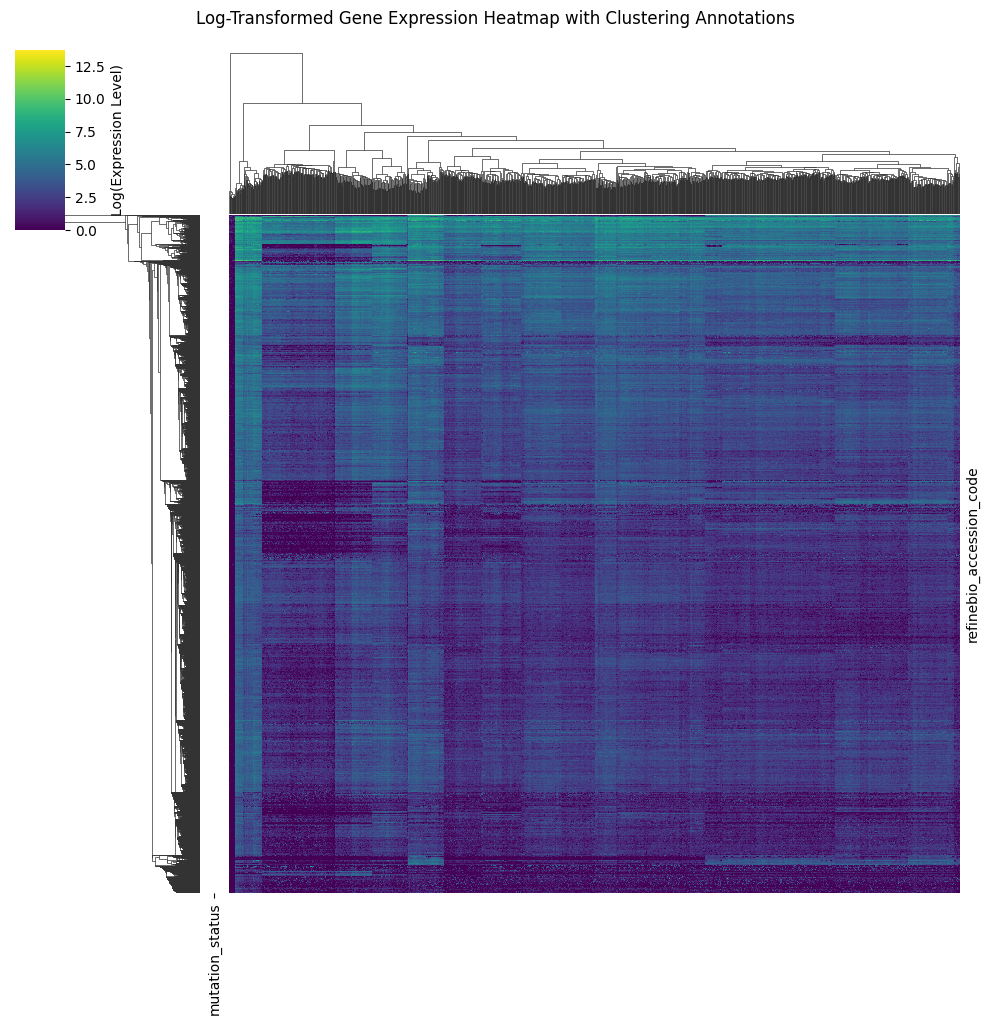

In [66]:
import numpy as np

# Apply log transformation to normalize expression levels
expression_log_transformed = np.log1p(expression_subset)

# Create the heatmap with log-transformed data
plt.figure(figsize=(15, 10))
sns.clustermap(
    expression_log_transformed,
    cmap='viridis',
    row_cluster=True,
    col_cluster=True,
    row_colors=sample_annotations['mutation_status'].map({'mutant': 'red', 'reference': 'blue'}),
    yticklabels=False,
    xticklabels=False,
    cbar_kws={'label': 'Log(Expression Level)'}
)

plt.suptitle("Log-Transformed Gene Expression Heatmap with Clustering Annotations", y=1.02)
plt.show()
